In [1]:
from argparse import ArgumentParser
from datetime import datetime
from typing import Optional
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F
import pandas as pd

#Data
from readers.data import GensimDataModule, W2VVocab, ReaderVocab

#Model
from gensim.models import KeyedVectors
from readers.DrQA.config import add_model_args
from readers import modules as reader_module
from readers.DrQA.lightningmodule import DrQA

from readers.DrQA import config as DrQAConfig

#Optim
from torch.optim import AdamW

# Logger
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Metrics
from pytorch_lightning.metrics.classification import F1
from pytorch_lightning.metrics import Accuracy

# Config

Chỉnh sửa config `--question-merge-self-attn` thành `n` để không dùng self attn ở trên bilstm.  
Chỉnh sửa config `--num-attn-head` thành `0` để không dùng encodemodule khi attent giữa question và context trước khi đưa vào rnn

In [2]:
def parse_args(args=None):
    parser = ArgumentParser()
    parser = pl.Trainer.add_argparse_args(parser)
    parser = GensimDataModule.add_argparse_args(parser)
    parser = DrQA.add_model_specific_args(parser)
    parser.add_argument('--seed', type=int, default=42)
    return parser.parse_args(args)

mocked_args = """
    --hidden-size 300
    --num-features 2
    --embedding-dim 300
    --context-layers 3
    --question-layers 2
    --concat-rnn-layers y
    --question-merge-self-attn n
    --rnn-type lstm
    --num-attn-head 4
    --dropout-rnn 0.2
    --dropout-emb 0.1
    --layernorm-emb y
    --dropout-rnn-output n
    --max_epochs 20
    --gpus 1
    --learning-rate 0.001
    --adam-epsilon 1e-8
    --weight-decay 1e-1
    --warmup-steps 40
    --max_seq_length 200
    --train_batch_size 64
    --eval_batch_size 64""".split()

args = parse_args(mocked_args)
pl.seed_everything(args.seed)

42

# Prepare Word Embedding

In [3]:
wv_path = 'wordembedding/pretrain_models/word2vec/baomoi.window2.vn.model.bin'
wv = KeyedVectors.load_word2vec_format(wv_path,binary=True)
vocab = W2VVocab(['<unk>', '<pad>', '<cls>'], 0, 1, wv)
ner_vocab = ReaderVocab.from_file('dataset/vocabs/train_feat_ner_vocab.txt')
ner_vocab.UNK='<unk>'
pos_vocab = ReaderVocab.from_file('dataset/vocabs/train_feat_pos_vocab.txt')
pos_vocab.UNK='<unk>'
w_in_train = []
with open('dataset/vocabs/zlqa_token_list.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        w_in_train.append(line.split(' ')[-1][:-1].lower())

# Prepare Dataset

In [4]:
BASE_DATASET_DIR = "dataset/qaset"
NORM_DATASET_DIR = "dataset/qaset/normset/set1"

In [5]:
train_df = pd.read_csv(f'{NORM_DATASET_DIR}/train_filted_feature.csv').sample(frac=1).reset_index(drop=True)
aug_df = pd.read_csv(f'{NORM_DATASET_DIR}/train_filted_feature.csv').sample(frac=1).reset_index(drop=True)
valid_df = pd.read_csv(f'{NORM_DATASET_DIR}/valid_filted_feature.csv').sample(frac=1).reset_index(drop=True)
test_df = pd.read_csv(f'{NORM_DATASET_DIR}/test_filted_feature.csv').sample(frac=1).reset_index(drop=True)

In [6]:
dm = GensimDataModule.from_argparse_args(args,vocab=vocab,pos_vocab=pos_vocab, ner_vocab=ner_vocab)
dm.prepare_data()
# dm.setup('fit', [train_df, valid_df, aug_df)])
dm.setup('fit', train_df, valid_df, test_df=test_df, aug_df=aug_df)

len aug 12676


In [7]:
# next(iter(dm.train_dataloader()))
len(dm.train_dataloader())

397

# Training

In [8]:
model = DrQA(vocab, [len(pos_vocab), len(ner_vocab)], **vars(args))
model.embedding.load_embeddings(w_in_train, wv)

Loaded 24631 embeddings (100.00%)


In [9]:
print(model)

DrQA(
  (embedding): EmbeddingModule(
    (embedding): Embedding(439057, 300, padding_idx=1)
    (layernorm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embedding_feature): ModuleList(
    (0): Embedding(29, 1, padding_idx=1)
    (1): Embedding(12, 1, padding_idx=1)
  )
  (network): RnnDocReader(
    (qemb_match): EncodeModule(
      (linear1): Linear(in_features=302, out_features=604, bias=True)
      (linear2): Linear(in_features=604, out_features=302, bias=True)
      (norm1): LayerNorm((302,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((302,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (mul_head): Multihead(
        (proj_Q): LinearWithChannel()
        (proj_K): LinearWithChannel()
        (proj_V): LinearWithChannel()
        (linear_out): Linear(in_features=1208, out_features=302, bias=True)
      )
    )
    (context_rnn): CustomBRNN(
      (rnns): Modu

In [10]:
logger = TensorBoardLogger('tb_logs', name='DrQA01_without_self_attn_above_rnn_aug')

In [11]:
checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='model-{epoch:02d}-{val_loss:.2f}',mode='min')

In [12]:
trainer = pl.Trainer.from_argparse_args(args, logger=logger, auto_lr_find=True, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name              | Type             | Params
-------------------------------------------------------
0 | embedding         | EmbeddingModule  | 131 M 
1 | embedding_feature | ModuleList       | 41    
2 | network           | RnnDocReader     | 14.1 M
3 | loss_fct          | CrossEntropyLoss | 0     
4 | train_acc         | Accuracy         | 0     
5 | valid_acc         | Accuracy         | 0     
6 | train_f1          | F1               | 0     
7 | valid_f1          | F1               | 0     
-------------------------------------------------------
145 M     Trainable params
0         Non-trainable params
145 M     Total params


LR finder stopped early due to diverging loss.


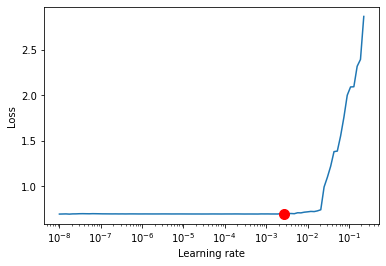

In [13]:
lr_finder = trainer.tuner.lr_find(model, train_dataloader=dm.train_dataloader())
fig = lr_finder.plot(suggest=True)
fig.show()

In [14]:
model.hparams.learning_rate = 3e-3

In [15]:
trainer.fit(model, dm)


  | Name              | Type             | Params
-------------------------------------------------------
0 | embedding         | EmbeddingModule  | 131 M 
1 | embedding_feature | ModuleList       | 41    
2 | network           | RnnDocReader     | 14.1 M
3 | loss_fct          | CrossEntropyLoss | 0     
4 | train_acc         | Accuracy         | 0     
5 | valid_acc         | Accuracy         | 0     
6 | train_f1          | F1               | 0     
7 | valid_f1          | F1               | 0     
-------------------------------------------------------
145 M     Trainable params
0         Non-trainable params
145 M     Total params


/python/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1